1/1 [==============================] - 0s 10ms/step


/var/folders/q_/s86qy4dx6sj5j58slv3z77840000gn/T/ipykernel_18555/3998234009.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


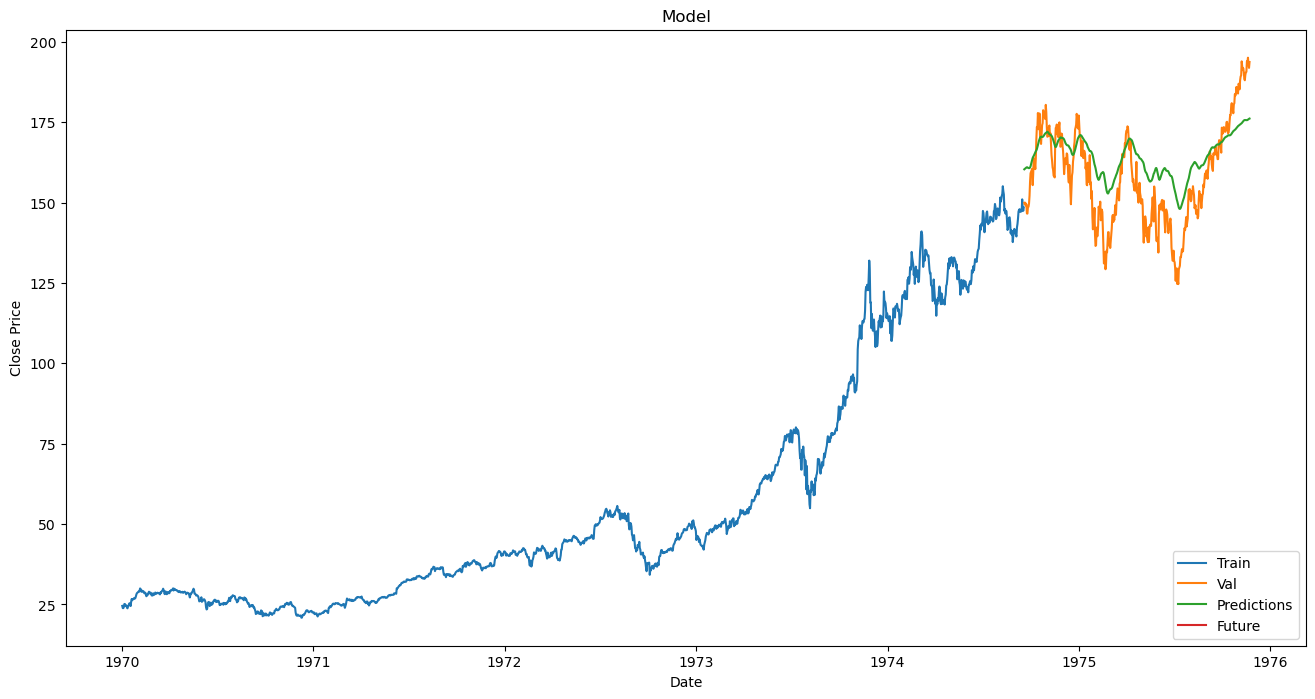

MSE: 134.65666544105585
RMSE: 11.604165865802498
MAPE: 6.4338003715347325%


/var/folders/q_/s86qy4dx6sj5j58slv3z77840000gn/T/ipykernel_18555/3998234009.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [15]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import boto3
import json
import os

# Set environment variables
with open('/Users/cedrix/Documents/aws.json', 'r') as f:
    credentials = json.load(f)
os.environ['AWS_ACCESS_KEY_ID'] = credentials['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials['AWS_SECRET_ACCESS_KEY']

# AWS S3 bucket
bucket = 'raw-stock-price'

def load_data_from_s3(stock_name):
    file_name = f'yhoofinance-daily-historical-data/{stock_name}_daily_data.csv'
    s3 = boto3.client('s3', aws_access_key_id=credentials['AWS_ACCESS_KEY_ID'], aws_secret_access_key=credentials['AWS_SECRET_ACCESS_KEY'])
    obj = s3.get_object(Bucket=bucket, Key=file_name)
    df = pd.read_csv(obj['Body'])
    return df

def train_lstm_model(data, look_back, lstm_units, batch_size, epochs, learning_rate, optimizer, loss):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['adj_close'].values.reshape(-1,1))

    data_len = len(scaled_data)
    train_len = int(data_len * 0.8)
    train_data = scaled_data[0:train_len]
    test_data = scaled_data[train_len - look_back:]

    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], 1), recurrent_regularizer=L2(0.01)))
    model.add(LSTM(units=lstm_units, return_sequences=False, recurrent_regularizer=L2(0.01)))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss)
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

    return model, scaler, train_data, test_data, X_test, Y_test

def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

def plot_predictions(data, train_len, predictions, future_predictions, future_days):
    train = data[:train_len]
    valid = data[train_len:]
    valid['Predictions'] = predictions
    future_dates = pd.date_range(start=valid.index[-1], periods=future_days+1)[1:]  # create future dates
    future = pd.DataFrame(future_predictions, index=future_dates, columns=['Future Predictions'])
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(train['adj_close'])
    plt.plot(valid[['adj_close', 'Predictions']])
    plt.plot(future['Future Predictions'])
    plt.legend(['Train', 'Val', 'Predictions', 'Future'], loc='lower right')
    plt.show()

def calculate_metrics(valid, predictions):
    mse = mean_squared_error(valid['adj_close'], predictions)
    print(f'MSE: {mse}')

    rmse = sqrt(mse)
    print(f'RMSE: {rmse}')

    mape = np.mean(np.abs((valid['adj_close'] - valid['Predictions']) / valid['adj_close'])) * 100
    print(f'MAPE: {mape}%')

def main():
    st.title("Stock Price Prediction with LSTM")
    st.sidebar.title("Model Hyperparameters")
    stock_name = st.sidebar.selectbox("Select a stock", ("AAPL", "GOOG", "MSFT", "AMZN"))
    look_back = st.sidebar.slider("Look-back period", min_value=1, max_value=100, value=50, step=1)
    lstm_units = st.sidebar.slider("Number of LSTM units", min_value=1, max_value=100, value=50, step=1)
    batch_size = st.sidebar.slider("Batch size", min_value=1, max_value=100, value=1, step=1)
    epochs = st.sidebar.slider("Number of epochs", min_value=1, max_value=100, value=1, step=1)
    learning_rate = st.sidebar.slider("Learning rate", min_value=0.001, max_value=0.1, value=0.01, step=0.001)
    optimizer = st.sidebar.selectbox("Optimizer", ("Adam", "SGD", "RMSprop"))
    loss = st.sidebar.selectbox("Loss function", ("mean_squared_error", "mean_absolute_error", "logcosh"))
    future_days = st.sidebar.slider("Future days to predict", min_value=1, max_value=30, value=1, step=1)

    data = load_data_from_s3(stock_name)
    model, scaler, train_data, test_data, X_test, Y_test = train_lstm_model(data, look_back, lstm_units, batch_size, epochs, learning_rate, optimizer, loss)

    st.write(f"Trained LSTM model for {stock_name} with look-back period = {look_back}, LSTM units = {lstm_units}, batch size = {batch_size}, epochs = {epochs}, learning rate = {learning_rate}, optimizer = {optimizer}, loss function = {loss}")

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    input_data = scaler.transform(data['adj_close'].values.reshape(-1,1))[-look_back:]  # start with the last 50 days of data
    future_predictions = []
    for _ in range(future_days):
        pred = model.predict(input_data.reshape(1, -1, 1))  # make a prediction
        future_predictions.append(pred[0, 0])  # store the prediction
        input_data = np.roll(input_data, -1)  # shift the data
        input_data[-1] = pred  # insert the prediction at the end

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

    plot_predictions(data, len(train_data), predictions, future_predictions, future_days)

    valid = data[len(train_data):len(train_data)+len(predictions)]
    valid['Predictions'] = predictions
    calculate_metrics(valid, predictions)

if __name__ == "__main__":
    main()